# Food project


![image.jpg](image.jpg)

## Discovery (identificazione del problema e degli obiettivi)

Negli ultimi secoli la popolazione mondiale è aumentata notevolmente e secondo l'ONU (fonte del 2019), nel 2050 potrebbe arrivare a quota *10 miliardi*. 

In maniera direttamente proporzionale **sono aumentate anche le domande di cibo, energia ed acqua**, per soddisfare questo bisogno. 

Sfortunamente, i costanti monitoraggi sul cambiamento climatico suggeriscono che il clima della Terra sta cambiando pericolosamente e *parte di questo effetto è direttamente correlato alla produzione agricola e all'allevamento*:

- la produzione alimentare richiede acqua ed energia; 
- la produzione energetica tradizionale richiede risorse idriche; 
- l'agricoltura fornisce una potenziale fonte di energia e tanta acqua. 
 
Garantire che nel mondo tutte le persone abbiano accesso a una dieta nutriente *in modo sostenibile* è una delle maggiori sfide che dobbiamo affrontare. 


> **L'obiettivo di questo notebook** è quello di sfruttare alcuni dati inerenti alla *produzione e distribuzione mondiale di alimenti e mangimi*, per valutarne il loro impatto sull'ambiente in termini di *utilizzo di risorse idriche ed emissioni di gas serra*.

### Principali spunti e domande che guideranno questa analisi:

1. Il confronto tra produzione di cibo e mangime a livello mondiale

2. Quali paesi sono i maggiori produttori di cibo e mangimi e come è variata la loro produzione negli anni? 

3. Sono presenti interessanti outlier nei dati per quanto riguarda la produzione?

4. Quali tipi di alimenti hanno un impatto maggiormente negativo sull'ambiente?

5. Quale fase della produzione alimentare contribuisce maggiormente all'emissione di gas serra?

6. Quali tipi di produzione alimentare dovrebbero essere incoraggiati per il consumo di una dieta maggiormente sostenibile per l'ambiente?

---
---

## Data selection

Questo progetto sfrutta due datasets caricati su Kaggle: 

- Il [primo](https://www.kaggle.com/datasets/dorbicycle/world-foodfeed-production), fornito dalla **FAO (Food and Agriculture Organization of the United Nations)**, mostra una panoramica della produzione alimentare mondiale *dal 1961 al 2013*, concentrandosi su un confronto tra **alimenti prodotti per il consumo umano** (denominati 'food') e **mangimi** (denominati 'feed') prodotti per l'allevamento di animali.

- Il [secondo](https://www.kaggle.com/datasets/selfvivek/environment-impact-of-food-production) contiene i valori di utilizzo dell'*acqua*, di emissioni di *gas serra*, ed altri valori di emissione necessari per la realizzazione dei **43 alimenti più comuni** prodotti nel mondo.

### Import di dati, moduli e funzioni utili

In [127]:
# Librerie fondamentali
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Librerie utili
from zipfile import ZipFile
from fuzzywuzzy import process
import fuzzywuzzy

pd.set_option('display.max_columns', None)

In [128]:
# Funzione personalizzata

def zip_extractor():
    """This function looks for zip files and extracts them in the same file path of this script, or in a folder provided 
    with an input. If the folder doesn't exist, it will be created with the provided (capitalized) name."""
    
    destination = input('Where do you want to put the extracted files?\n\
Press enter if you want to extract files in the current path, or write a folder name: ').capitalize()

    if destination == '':
        pass
    elif destination not in os.listdir():
        os.mkdir(destination)

    for dirname, _, filenames in os.walk(os.getcwd()):
        if dirname != 'Zip files':
            for filename in filenames:
                if '.zip' in filename:
                    with ZipFile(filename, "r") as zip:
                        zip.extractall(f'{destination}')

    print("Extraction: Done")

In [129]:
# Importo i files zip dei due dataset usando le API di Kaggle e li estraggo in una cartella

# !kaggle datasets download -d dorbicycle/world-foodfeed-production
# !kaggle datasets download -d selfvivek/environment-impact-of-food-production
# zip_extractor()

In [130]:
# Dataset della produzione di cibi/mangimi dei vari paesi del mondo
fao_df = pd.read_csv('Data/Fao.csv')
df_prod = fao_df.copy()

# Dataset delle emissioni di gas serra e dei consumi di acqua per la produzione di alimenti
emission_df = pd.read_csv('Data/Food_Production.csv')
df_emiss = emission_df.copy()

---
---
## Data cleaning

### Dataset della produzione di cibi/mangimi dei vari paesi del mondo

In [131]:
df_prod.head()

,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,Y1971,Y1972,Y1973,Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,Y1980,Y1981,Y1982,Y1983,Y1984,Y1985,Y1986,Y1987,Y1988,Y1989,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,AFG,2,Afghanistan,2511,Wheat and products,5142,Food,1000 tonnes,33.94,67.71,1928.0,1904.0,1666.0,1950.0,2001.0,1808.0,2053.0,2045.0,2154.0,1819.0,1963.0,2215.0,2310.0,2335.0,2434.0,2512.0,2282.0,2454.0,2443.0,2129.0,2133.0,2068.0,1994.0,1851.0,1791.0,1683.0,2194.0,1801.0,1754.0,1640.0,1539.0,1582.0,1840.0,1855.0,1853.0,2177.0,2343.0,2407.0,2463.0,2600.0,2668.0,2776.0,3095.0,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,AFG,2,Afghanistan,2805,Rice (Milled Equivalent),5142,Food,1000 tonnes,33.94,67.71,183.0,183.0,182.0,220.0,220.0,195.0,231.0,235.0,238.0,213.0,205.0,233.0,246.0,246.0,255.0,263.0,235.0,254.0,270.0,259.0,248.0,217.0,217.0,197.0,186.0,200.0,193.0,202.0,191.0,199.0,197.0,249.0,218.0,260.0,319.0,254.0,326.0,347.0,270.0,372.0,411.0,448.0,460.0,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,AFG,2,Afghanistan,2513,Barley and products,5521,Feed,1000 tonnes,33.94,67.71,76.0,76.0,76.0,76.0,76.0,75.0,71.0,72.0,73.0,74.0,71.0,70.0,72.0,76.0,77.0,80.0,60.0,65.0,64.0,64.0,60.0,55.0,53.0,51.0,48.0,46.0,46.0,47.0,46.0,43.0,43.0,40.0,50.0,46.0,41.0,44.0,50.0,48.0,43.0,26.0,29.0,70.0,48.0,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,AFG,2,Afghanistan,2513,Barley and products,5142,Food,1000 tonnes,33.94,67.71,237.0,237.0,237.0,238.0,238.0,237.0,225.0,227.0,230.0,234.0,223.0,219.0,225.0,240.0,244.0,255.0,185.0,203.0,198.0,202.0,189.0,174.0,167.0,160.0,151.0,145.0,145.0,148.0,145.0,135.0,132.0,120.0,155.0,143.0,125.0,138.0,159.0,154.0,141.0,84.0,83.0,122.0,144.0,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,AFG,2,Afghanistan,2514,Maize and products,5521,Feed,1000 tonnes,33.94,67.71,210.0,210.0,214.0,216.0,216.0,216.0,235.0,232.0,236.0,200.0,201.0,216.0,228.0,231.0,234.0,240.0,228.0,234.0,228.0,226.0,210.0,199.0,192.0,182.0,173.0,170.0,154.0,148.0,137.0,144.0,126.0,90.0,141.0,150.0,159.0,108.0,90.0,99.0,72.0,35.0,48.0,89.0,63.0,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


#### Valori nulli

Procedo verificando la presenza di valori nulli (*NaN*) nel dataset, o altri valori incoerenti. Se effettivamente presenti, approfondisco l'analisi per sapere quanti sono e in quali colonne sono maggiormente frequenti. Inoltre, proverò a fare un *imputation*, ovvero a stabilire il motivo della loro presenza. 

In [132]:
print(f'Dimensioni del dataframe: {df_prod.shape}')

# Quante celle contengono valori nulli rispetto alle celle totali?
total_cells = np.product(df_prod.shape)
print(f'Numero totale di celle: {total_cells}')

total_missing = df_prod.isnull().sum().sum()
print(f'Numero totale di celle con valori nulli: {total_missing}')

percent_missing = round(total_missing/total_cells * 100, 2)
print(f'\nPercentuale di valori nulli in questo Dataframe: {percent_missing}%')

Dimensioni del dataframe: (21477, 63)
Numero totale di celle: 1353051
Numero totale di celle con valori nulli: 117450

Percentuale di valori nulli in questo Dataframe: 8.68%


In [133]:
pd.set_option('display.max_rows', 63)

# Costruisco una tabella riassuntiva sui Dtype, valori unici e valori nulli di tutte le colonne
print("Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:")

df_prod_info= pd.DataFrame({"Dtype": df_prod.dtypes, 
                            "Valori unici": df_prod.nunique(),
                            "Valori mancanti(%)": round(df_prod.isnull().sum()/df_prod.shape[0]*100, 2)
                            }).rename_axis('Colonne', axis='rows')                       

# Questa tabella riassuntiva si ispira moltissimo alla funzione 'dataframe.info()'. 
# Però in questo caso, la lettura dei valori mancanti è più semplice ed immediata.
df_prod_info

Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:


,Dtype,Valori unici,Valori mancanti(%)
Colonne,,,
Area Abbreviation,object,169,0.00
Area Code,int64,174,0.00
Area,object,174,0.00
Item Code,int64,117,0.00
Item,object,115,0.00
Element Code,int64,2,0.00
Element,object,2,0.00
Unit,object,1,0.00
latitude,float64,173,0.00


Si vede chiaramente che la maggior parte dei valori nulli presenti nel dataset è concentrata nelle colonne *tra il 1961 e il 1991*. Come si può leggere tra la documentazione nella pagina Kaggle dove è fornito il dataset:

>The Food Balance sheet's data was relatively complete. A few countries that do not exist anymore, such as Czechoslovakia, were deleted from the database. Countries which were formed lately such as South Sudan were kept, even though they do not have all full data going back to 1961. [...]

Quindi, in un certo senso, sembrerebbe che particolari *evoluzioni geopolitiche di alcuni paesi* siano la causa dell'indisponibilità dei dati.  

Prendo un campione a caso dove sono presenti questi valori nulli, cercando di fare chiarezza e di confermare le informazioni contenute nella documentazione del dataset.  

In [134]:
# Creo una lista con gli indici delle righe che contengono i valori nulli
rows_with_missing = df_prod.loc[df_prod.isnull().any(axis=1)].index.to_list()
print(f'\nNumero di righe con valori nulli: {len(rows_with_missing)}')

# Imposto un random seed per rendere pseudorandomica e riproducibile questa cella
np.random.seed(0)

# Utilizzo la lista per creare un dataframe avente solo le righe che contengono valori nulli
df_null_rows = df_prod.loc[rows_with_missing]

# Seleziono un campione a caso di 5 elementi
df_null_rows.sample(5)


Numero di righe con valori nulli: 3539


,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,Y1971,Y1972,Y1973,Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,Y1980,Y1981,Y1982,Y1983,Y1984,Y1985,Y1986,Y1987,Y1988,Y1989,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
17328,SVK,199,Slovakia,2517,Millet and products,5521,Feed,1000 tonnes,48.67,19.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1,1
13020,MNE,273,Montenegro,2617,Apples and products,5142,Food,1000 tonnes,42.71,19.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,19.0,34.0,38.0,33.0,27.0,14,13
17526,SVN,198,Slovenia,2733,Pigmeat,5142,Food,1000 tonnes,46.15,15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,81.0,84.0,75.0,70.0,73.0,77.0,87.0,76.0,82.0,78.0,88.0,88.0,88.0,89.0,84.0,84.0,80.0,81.0,76.0,69,58
11128,LVA,119,Latvia,2656,Beer,5142,Food,1000 tonnes,56.88,24.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,53.0,66.0,67.0,66.0,73.0,82.0,100.0,99.0,105.0,134.0,142.0,124.0,144.0,147.0,158.0,156.0,146.0,164.0,172.0,163,156
16103,RUS,185,Russian Federation,2560,Coconuts - Incl Copra,5142,Food,1000 tonnes,61.52,105.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,2.0,2.0,10.0,10.0,21.0,28.0,42.0,45.0,47.0,52.0,45.0,59.0,42.0,39.0,48.0,63.0,57,63


Possiamo vedere che in questi 5 paesi selezionati a caso ('Slovacchia', 'Montenegro', 'Slovenia', 'Lettonia' e 'Federazione Russa'), in effetti i dati di produzione sono mancanti dal 1961 al 1991 (il Montenegro fino al 2005). 

Cercando informazioni sulla storia geopolitica di questi paesi (fonte: [Wikipedia](https://it.wikipedia.org/wiki/Pagina_principale)) si può leggere:

- *Slovacchia*: [...] La Repubblica Slovacca e la Repubblica Ceca sono nate il 1º gennaio 1993 dalla divisione, sancita dal parlamento della Cecoslovacchia, che **già dal 1990 aveva assunto il nome di Repubblica Federale Ceca e Slovacca**;

- *Montenegro*: [...] Fino al 2 giugno 2006 la Repubblica del Montenegro è stata unita alla Repubblica di Serbia con il nome di Serbia e Montenegro. **Dal 3 giugno 2006 il Montenegro è diventato uno Stato indipendente**;

- *Slovenia*: [...] Dal 1º maggio 2004 la Slovenia è membro dell'Unione europea e la valuta nazionale, dal 1º gennaio 2007, è l'euro, che ha sostituito il tallero sloveno, adottato **nel 1991 dopo l'indipendenza** [...];

- *Lettonia*: [...] L'URSS riconobbe **la Lettonia come Stato indipendente il 6 settembre 1991** [...];

- *Federazione Russa*: [...] Nell'agosto del 1991 il tentato colpo di Stato militare per deporre Gorbačëv e preservare l'Unione Sovietica portò invece alla fine del Partito Comunista dell'Unione Sovietica. Nonostante la contraria volontà espressa dal popolo, **il 26 dicembre 1991 l'Unione Sovietica si dissolse in quindici Stati post-sovietici**.

Questo risultato **è in linea con la documentazione** del dataset, giustificando il retroscena che riguarda la presenza di valori mancanti.

**È conveniente** eliminare dal dataframe le righe che contengono valori nulli, oppure si rischia di perdere un numero **eccessivo** di informazioni?

In [135]:
# Creo un dataframe droppando le righe che contengono valori nulli 
# 'rd' sta per 'row dropped'
df_prod_rd = df_prod.dropna()

# Calcolo la percentuale di dati eliminati rispetto dal dataframe originale
rows_removal_perc = round((1-df_prod_rd.shape[0]/df_prod.shape[0])*100,2)

# Stampo le informazioni sul numero di righe totali e la shape dei due dataframes
print(f"\nRighe del dataframe originale: {df_prod.shape[0]}. Shape del dataframe originale: {df_prod.shape}")
print(f"Righe del dataframe dopo aver rimosso i valori mancanti: {df_prod_rd.shape[0]}.\
Shape del dataframe modificato: {df_prod_rd.shape}")
print(f'\nLa rimozione delle righe che contengono valori NaN ha eliminato il {rows_removal_perc}% dei dati!')


Righe del dataframe originale: 21477. Shape del dataframe originale: (21477, 63)
Righe del dataframe dopo aver rimosso i valori mancanti: 17938.Shape del dataframe modificato: (17938, 63)

La rimozione delle righe che contengono valori NaN ha eliminato il 16.48% dei dati!


Avrei anche potuto sostituire i valori NaN con 0 tramite *fillna()*. Tuttavia, voglio visualizzare la produttività dei vari paesi nell'arco temporale più lungo possibile. Inoltre, secondo me, operando in questo modo **si perdono quantità tollerabili di dati**. Quindi, continuerò lo studio di questo dataset adottando questa procedura.

#### Cleaning variabili qualitative

##### Esplorazione e manipolazione della colonna 'Area'

Questa procedura sarà fondamentale per garantire che i nomi dei paesi non saranno presenti come duplicati, formattati in maniera impropria, o aventi qualsiasi altra incorrettezza. 

In [136]:
# Uso una nomeclatura più semplice per richiamare il dataframe della produzione di cibo/mangimi
df = df_prod_rd.copy()

In [137]:
# Creo una serie per vedere se alcune etichette di 'Area Abbreviation' sono state utilizzate per più di un paese
find_duplicates = df.groupby('Area Abbreviation')['Area'].nunique()
find_duplicates[find_duplicates > 1]

Area Abbreviation
CHN    4
Name: Area, dtype: int64

In [138]:
# Uso l'etichetta 'CHN' per creare un filtro
chn_filter = df['Area Abbreviation'].isin(['CHN'])

# Uso il filtro per estrapolare un dataframe composto solo da paesi con etichetta 'CHN'
chn_df = df.loc[chn_filter]

# Creo una lista dall'array dei valori unici nella colonna 'Area' 
chn_countries = chn_df.Area.unique().tolist()

# Print informativo
print(f"Lista dei Paesi che condividono l'etichetta 'CHN':\n{chn_countries}\n\n\
Sostituirò questi nomi con:\n'China'")

# Sostituisco i nomi delle località presenti nella lista chn_countries con 'China' usando un dictionary comprehension
df.Area.replace({n:'China' for n in chn_countries}, inplace=True)

Lista dei Paesi che condividono l'etichetta 'CHN':
['China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland', 'China, Taiwan Province of']

Sostituirò questi nomi con:
'China'


Sfruttando le etichette di 'Area Abbreviation' è stato facile rimpiazzare le voci. Come fare però a controllare tutti gli altri nomi dei paesi presenti nella colonna 'Area'? 

Uno strumento utilissimo per controllare contemporaneamente tutte le incongruenze tra diversi elementi è *fuzzywuzzy*. 

Questo strumento utilizza la [Distanza di Levenshtein](https://it.wikipedia.org/wiki/Distanza_di_Levenshtein) per misurare le differenze fra due stringhe e determinare quanto queste siano simili tra loro, assegnando un punteggio. Più è elevato il punteggio, maggiore sarà la somiglianza tra le due stringhe. 

La mia strategia sarà la seguente:

- Creo una lista dei valori unici dei paesi racchiusi nella colonna 'Area';

- Creo un ciclo che itera sul nome di ogni paese della lista, restitundo a sua volta una lista di tuple composte da due elementi: nome del paese di confronto e punteggio assegnato;

    - La prima tupla avrà il punteggio massimo (100) poiché corrisponde al confronto dell'elemento che sta attualmente iterando nel ciclo con sè stesso;

    - Dalla seconda tupla in poi, invece, si ritrovano le effettive somiglianze tra il nome dell'elemento preso in considerazione e i nomi di tutti gli altri elementi. Quindi, imposto un punteggio minimo "di somiglianza" come valore soglia per fare dei confronti;

>
- Introduco il tutto in un dizionario per rendere l'output più facile da leggere;

- Guardo l'output e valuto le eventuali modifiche da fare.

In [139]:
# Lista da testare con tutti i nomi unici dei paesi
test = df.Area.unique().tolist()

# Inizializzo un dizionario  
top_matches = {}

for item in test:

    # Dopo qualche test ho valutato che conviene fare un confronto tra i primi 3 elementi...
    # (limit=4 poichè la prima tupla conterrà l'elemento sul quale il ciclo sta iterando)
    matches = fuzzywuzzy.process.extract(item, test, limit=4, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    
    # ...ed imporre il valore soglia >= 80!
    treshold = matches[1][1]

    if treshold >= 80:        

        # Le chiavi del dizionario corrisponderanno ai nomi dei paesi sul quale il ciclo sta iterando    
        key = item 
        
        # I valori corrisponderanno ai nomi dei paesi ottenuti per miglior match
        values = [matches[n][0] for n in range(1,4)]
        
        # Introduco chiavi e valori nel dizionario  
        top_matches[key] = values

for key, values in top_matches.items():
    print(f"Elemento in esame: {key}\nMigliori matches: {values}\n")
    print('-'*90)

Elemento in esame: Australia
Migliori matches: ['Austria', 'Mauritania', 'Guatemala']

------------------------------------------------------------------------------------------
Elemento in esame: Austria
Migliori matches: ['Australia', 'Costa Rica', 'Mauritania']

------------------------------------------------------------------------------------------
Elemento in esame: Democratic People's Republic of Korea
Migliori matches: ["Lao People's Democratic Republic", 'Republic of Korea', 'Iran (Islamic Republic of)']

------------------------------------------------------------------------------------------
Elemento in esame: Gambia
Migliori matches: ['Zambia', 'Namibia', 'Cambodia']

------------------------------------------------------------------------------------------
Elemento in esame: Iceland
Migliori matches: ['Ireland', 'Finland', 'Switzerland']

------------------------------------------------------------------------------------------
Elemento in esame: Ireland
Migliori matches

Come si può vedere, non ci sono pesanti incongruenze da sistemare tra i nomi dei paesi. C'è solo qualche ritocco da fare per semplificare la lettura di alcuni nomi. 

In [140]:
# Creo una lista con i paesi che presentano parentesi nell' etichetta del nome 
bracket = [country for country in df.Area.unique().tolist() if '(' in country.lower()]

# Creo una lista in cui inserire il loro nome seprato da tutto il resto
split_bracket = [country.split()[0] for country in bracket]

# Print informativo
print(f'Lista dei paesi con parentesi:\n{bracket}\n\n\
Lista dei paesi dopo aver rimosso le parentesi:\n{split_bracket}')

# Sostituisco i nuovi nomi con un metodo simile a quello di prima
df.Area.replace({bracket[n]:split_bracket[n] for n in range(len(bracket))}, inplace=True)

Lista dei paesi con parentesi:
['Bolivia (Plurinational State of)', 'Iran (Islamic Republic of)', 'Venezuela (Bolivarian Republic of)']

Lista dei paesi dopo aver rimosso le parentesi:
['Bolivia', 'Iran', 'Venezuela']


In [141]:
# Cerco i Paesi che hanno 'of' nel nome
of_names = [country for country in df.Area.unique().tolist() if 'of' in country.lower()]

# Formatto i nomi assegnando nomenclature maggiormente note
of_formatted = ['North Korea', 'South Korea', 'Tanzania', 'USA']

# Print informativo
print(f"Lista dei paesi con 'of' nel nome:\n{of_names}\n\n\
Lista dei paesi con le nuove nomenclature:\n{of_formatted}")

# Sostituisco i nuovi nomi con un metodo simile a quello di prima
df.Area.replace({of_names[n]:of_formatted[n] for n in range(len(of_names))}, inplace=True)

Lista dei paesi con 'of' nel nome:
["Democratic People's Republic of Korea", 'Republic of Korea', 'United Republic of Tanzania', 'United States of America']

Lista dei paesi con le nuove nomenclature:
['North Korea', 'South Korea', 'Tanzania', 'USA']


In [142]:
# Aggiusto questo nome "C�te d'Ivoire" in "Ivory Coast". È un problema di VS Code? 
df.Area.replace({"C�te d'Ivoire":'Ivory Coast'}, inplace=True)

# Infine, riordino i nomi dei paesi nel dataframe
df.sort_values('Area', inplace=True)

##### Esplorazione e manipolazione della colonna 'Item'

Ora passiamo ad analizzare la colonna che contiene i valori *più delicati* dei due datasets; diamo un'occhiata alle nomenclature dei cibi e dei mangimi. 

Vediamo se ci sono voci a comune tra cibi e mangimi, voci esclusive dei cibi e/o voci esclusive dei mangimi. 

In [143]:
# Creo un dataframe ordinato secondo le nomenclature degli alimenti/mangimi del dataframe PRODUZIONE 
sorted_prod = df.sort_values('Item')

# Ne estrapolo anche una lista che potrebbe tornare utile in seguito
sorted_all_food_feed = sorted_prod.Item.unique().tolist()
print(f"Totale dei nomi unici di CIBI e MANGIMI: {len(sorted_all_food_feed)}\n")

# Da questo dataframe ne ricavo un altro contenente SOLO i cibi, ottenendo anche in questo caso la lista ORDINATA
sorted_prod_FOOD = sorted_prod.loc[sorted_prod['Element'] == 'Food']
sorted_FOOD_list = sorted_prod_FOOD.Item.unique().tolist()

# Stessa operazione per il dataframe contenente SOLO i mangimi
sorted_prod_FEED = sorted_prod.loc[sorted_prod['Element'] == 'Feed']
sorted_FEED_list = sorted_prod_FEED.Item.unique().tolist()

# Lista di elementi a comune di food e feed
feed_food_common = [n for n in sorted_FOOD_list if n in sorted_FEED_list]
print('-'*100)
print(f"Elementi a comune tra CIBI e MANGIMI: {len(feed_food_common)}\n")
print(feed_food_common)

# Lista di elementi unici di food
unique_FOOD_list = [n for n in sorted_FOOD_list if n not in sorted_FEED_list]
print('-'*100)
print(f"Elementi esclusivi della lista dei CIBI non presenti in quella dei MANGIMI: {len(unique_FOOD_list)}\n")
print(unique_FOOD_list)

# Lista di elementi unici di feed
unique_FEED_list = [n for n in sorted_FEED_list if n not in sorted_FOOD_list]

if len(unique_FEED_list) > 0:

    print('-'*100)
    print(f'\nElementi esclusivi della lista dei MANGIMI non presenti in quella dei CIBI: {len(unique_FEED_list)}\n')
    print(unique_FEED_list)

else:
    print('-'*100)
    print(f'\nLa lista degli elementi esclusivi dei MANGIMI è vuota, quindi tutte le nomenclature dei MANGIMI sono già \
incluse tra quelle dei CIBI.')

Totale dei nomi unici di CIBI e MANGIMI: 115

----------------------------------------------------------------------------------------------------
Elementi a comune tra CIBI e MANGIMI: 82

['Animal fats', 'Apples and products', 'Aquatic Plants', 'Aquatic Products, Other', 'Bananas', 'Barley and products', 'Beans', 'Butter, Ghee', 'Cassava and products', 'Cephalopods', 'Cereals - Excluding Beer', 'Cereals, Other', 'Coconuts - Incl Copra', 'Cottonseed', 'Crustaceans', 'Dates', 'Demersal Fish', 'Eggs', 'Fats, Animals, Raw', 'Fish, Body Oil', 'Fish, Liver Oil', 'Fish, Seafood', 'Freshwater Fish', 'Fruits - Excluding Wine', 'Fruits, Other', 'Grapefruit and products', 'Grapes and products (excl wine)', 'Groundnuts (Shelled Eq)', 'Honey', 'Maize and products', 'Marine Fish, Other', 'Meat', 'Meat, Other', 'Milk - Excluding Butter', 'Millet and products', 'Molluscs, Other', 'Mutton & Goat Meat', 'Oats', 'Offals', 'Offals, Edible', 'Oilcrops', 'Oilcrops Oil, Other', 'Oilcrops, Other', 'Olive Oil

Il **punto critico** è che dovrei avere *congruenza tra i nomi degli alimenti* dei due datasets!

Per non complicare eccessivamente la pulizia dei dati, mi preoccuperò solo di avere una coerenza tra i nomi più rilevanti, *in termini di emissioni totali*, del dataset delle emissioni ed i loro corrispettivi nel dataset della produzione.

Idealmente, vorrei riusciure a rimpiazzare le prime *20* voci. Anche se non dovessi riuscire a rimpiazzarle tuttee 20 dovrei comunque ottenere un risultato ottimale per il successivo momento della visualizzazione. 

In [144]:
# Diamo un'occhiata al dataframe delle emissioni
df_emiss.head()

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),Eutrophying emissions per kilogram (gPO₄eq per kilogram),Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein),Freshwater withdrawals per 1000kcal (liters per 1000kcal),Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,11.23,8.638462,183.911552,371.076923,482.4,0.945482,1.907692,2.897446,7.6,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,35.07,49.394366,609.983722,3166.760563,2248.4,1.207271,6.267606,0.759631,2.8,3.943662,49576.3,69825.77465,13449.891480


In [145]:
# Devo prima ordinare il dataframe delle emissioni, in ordire decrescente, secondo la colonna 'Total_emissions'
emiss_sorted = df_emiss.sort_values('Total_emissions', ascending=False).head(20)

# Poi, per comodità, ordino alfabeticamente i 20 nomi...
emiss_sorted = emiss_sorted.sort_values('Food product')

# ...e ne estraggo la lista
top20_emission_sorted = emiss_sorted['Food product'].unique().tolist()
print(f"Lista dei 20 alimenti più rilevanti in termini di emissioni totali:\n\n{top20_emission_sorted}")

Lista dei 20 alimenti più rilevanti in termini di emissioni totali:

['Beef (beef herd)', 'Beef (dairy herd)', 'Cane Sugar', 'Cheese', 'Coffee', 'Dark Chocolate', 'Eggs', 'Fish (farmed)', 'Lamb & Mutton', 'Milk', 'Olive Oil', 'Palm Oil', 'Pig Meat', 'Poultry Meat', 'Rapeseed Oil', 'Rice', 'Shrimps (farmed)', 'Soybean Oil', 'Sunflower Oil', 'Tofu']



Anche in questo caso sfrutterò *fuzzywuzzy* per facilitarmi il lavoro, mentre il resto lo ricaverò osservando gli output ottenuti.

In [146]:
# Inizializzo un dizionario che avrà: 
dict_20elements = {}

for item in top20_emission_sorted:
    
    matches = fuzzywuzzy.process.extract(item, sorted_all_food_feed, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # Come chiavi i 20 nomi degli alimenti del dataframe delle emissioni     
    key = item 
    
    # Come valori la lista dei 10 nomi ottenuti per miglior punteggio con fuzzywuzzy 
    values = [matches[n][0] for n in range(10)]
    
    # Introduco chiavi e valori nel dizionario  
    dict_20elements[key] = values

for key, values in dict_20elements.items():
    print(f"Elemento in esame: {key}\nMigliori matches: {values}\n")
    print('-'*50)

Elemento in esame: Beef (beef herd)
Migliori matches: ['Beer', 'Cereals, Other', 'Meat, Other', 'Sugar beet', 'Sesame seed', 'Cereals - Excluding Beer', 'Fruits, Other', 'Barley and products', 'Sunflower seed', 'Groundnuts (Shelled Eq)']

--------------------------------------------------
Elemento in esame: Beef (dairy herd)
Migliori matches: ['Sugar beet', 'Cereals, Other', 'Beer', 'Oilcrops Oil, Other', 'Meat, Other', 'Groundnuts (Shelled Eq)', 'Aquatic Animals, Others', 'Cereals - Excluding Beer', 'Sesame seed', 'Fruits, Other']

--------------------------------------------------
Elemento in esame: Cane Sugar
Migliori matches: ['Sugar cane', 'Sugar beet', 'Sugar Crops', 'Sugar non-centrifugal', 'Sugar (Raw Equivalent)', 'Miscellaneous', 'Sunflower seed', 'Beans', 'Dates', 'Rape and Mustard Oil']

--------------------------------------------------
Elemento in esame: Cheese
Migliori matches: ['Cloves', 'Spices', 'Sesame seed', 'Spices, Other', 'Treenuts', 'Miscellaneous', 'Alcoholic B

Analizzando il precedente output, si ritrovano 4 situazioni differenti:

- Alcuni elementi corrispondono perfettamente;

- Altri necessitano solo una lieve modifica; 

- Altri sono termini generalizzati e probabilemente per questo si osserva l'incongruenza. 

- Altri ancora non hanno alcuna corrispondenza (forse perché introdotti nel dataframe della produzione secondo altre nomenclature).

In [147]:
# Questo dizionario è stato creato da un copia e incolla del precedente output. 
# Dopodiché ho eliminato tutti i valori tranne uno, quello maggiormente attinente col nome della chiave. 
inconsistencies_dict = {

  # NOTE: I nomi delle chiavi corrispondo ai nomi degli elementi del dataset delle EMISSIONI. 
  # NOTE: I nomi dei valori corrispondono invece a quelli del dataset della PRODUZIONE.

  # Incongruenza: probabilmente i valori sono generalizzati
  'Beef (beef herd)': 'Meat, Other',

  # Incongruenza: probabilmente i valori sono generalizzati
  'Beef (dairy herd)': 'Meat, Other',

  # Lieve incongruenza 
  'Cane Sugar': 'Sugar cane',

  # Incongruenza GRAVE: nessun valore corrispondente.
  'Cheese': 'NONE',

  # Lieve incongruenza 
  'Coffee': 'Coffee and products',
  
  # Incongruenza GRAVE: nessun valore corrispondente.
  'Dark Chocolate': 'NONE',

  # Perfettamente congruente
  'Eggs': 'Eggs',

  # Lieve incongruenza 
  'Fish (farmed)': 'Fish, Seafood',

  # Lieve incongruenza 
  'Lamb & Mutton': 'Mutton & Goat Meat',

  # Lieve incongruenza
  'Milk': 'Milk - Excluding Butter',
  
  # Perfettamente congruente
  'Olive Oil': 'Olive Oil',
  
  # Perfettamente congruente
  'Palm Oil': 'Palm Oil',
  
  # Lieve incongruenza
  'Pig Meat': 'Pigmeat',
  
  # Perfettamente congruente
  'Poultry Meat': 'Poultry Meat',
  
  # Lieve incongruenza 
  'Rapeseed Oil': 'Rape and Mustard Oil',
 
  # Incongruenza GRAVE: nessun valore corrispondente.
  'Rice': 'NONE',

  # Incongruenza GRAVE: nessun valore corrispondente.
  'Shrimps (farmed)': 'NONE',

  # Lieve incongruenza
  'Soybean Oil': 'Soyabean Oil',

  # Lieve incongruenza
  'Sunflower Oil': 'Sunflowerseed Oil',

  # Incongruenza GRAVE: nessun valore corrispondente.
  'Tofu': 'NONE'
  }

In [148]:
# Valori perfettamente congruenti: le nomenclature tra gli elementi dei due datasets sono identiche
right_elements = {key:value for (key, value) in inconsistencies_dict.items() if key == value}
print("Dizionario delle voci perfettamente congruenti tra i due datasets:")

right_elements

Dizionario delle voci perfettamente congruenti tra i due datasets:


{'Eggs': 'Eggs',
 'Olive Oil': 'Olive Oil',
 'Palm Oil': 'Palm Oil',
 'Poultry Meat': 'Poultry Meat'}

In [149]:
# NOTE: I nomi delle chiavi corrispondono ai nomi degli elementi del dataset delle EMISSIONI.
# NOTE: I nomi dei valori corrispondono invece a quelli del dataset della PRODUZIONE.

# Incongruenze lievi: le nomenclature tra gli elementi dei due datasets sono quasi identiche
slight_inconsistencies = {key:value for (key, value) in inconsistencies_dict.items() 
                          if key != value and value != 'NONE' and value != 'Meat, Other'}
print(f"Dizionario delle voci leggermente diverse, ma riferite allo stesso elemento:\n{slight_inconsistencies}\n")

# Poiché voglio che le modifiche vengano fatte nel dataframe delle produzioni, prima di rimpiazzare 
# i nomi nel dataframe delle produzioni, devo invertire le nomenclature di chiavi e valori.
reversed_slight_inc = {key:value for (value, key) in slight_inconsistencies.items()}
print(f"Dizionario con nomenclature invertite:\n{reversed_slight_inc}")

# Sostituisco i nomi nel dataframe della produzione di cibo/mangimi
df.Item.replace(reversed_slight_inc, inplace=True)

Dizionario delle voci leggermente diverse, ma riferite allo stesso elemento:
{'Cane Sugar': 'Sugar cane', 'Coffee': 'Coffee and products', 'Fish (farmed)': 'Fish, Seafood', 'Lamb & Mutton': 'Mutton & Goat Meat', 'Milk': 'Milk - Excluding Butter', 'Pig Meat': 'Pigmeat', 'Rapeseed Oil': 'Rape and Mustard Oil', 'Soybean Oil': 'Soyabean Oil', 'Sunflower Oil': 'Sunflowerseed Oil'}

Dizionario con nomenclature invertite:
{'Sugar cane': 'Cane Sugar', 'Coffee and products': 'Coffee', 'Fish, Seafood': 'Fish (farmed)', 'Mutton & Goat Meat': 'Lamb & Mutton', 'Milk - Excluding Butter': 'Milk', 'Pigmeat': 'Pig Meat', 'Rape and Mustard Oil': 'Rapeseed Oil', 'Soyabean Oil': 'Soybean Oil', 'Sunflowerseed Oil': 'Sunflower Oil'}


In [150]:
# Incongruenze tra elementi generalizzati: 'meat' e 'beef'
generalized_inconsistencies = {key: value for key, value in inconsistencies_dict.items() if value == 'Meat, Other'}
print(f"Dizionario delle voci non congruenti tra i due datasets per possibile generalizzazione:\
\n{generalized_inconsistencies}\n")

# Vado a cercare tra quali elementi del dataset delle PRODUZIONI compaiono le voci 'meat' e 'beef' e creo dei
# filtri per entrambi
meat = df.Item.map(lambda text: 'meat' in text.lower())
beef = df.Item.map(lambda text: 'beef' in text.lower())

# Ottengo la lista dei valori unici per entrambi
prod_meat_list = df.loc[meat].Item.unique().tolist()
prod_beef_list = df.loc[beef].Item.unique().tolist()

print(f"Elementi con la dicitura 'meat' nel dataframe della produzione:\n{prod_meat_list}\n")
print(f"Elementi con la dicitura 'beef' nel dataframe della produzione:\n{prod_beef_list}\n")

print("Conta dei valori degli elementi contenenti la parola 'meat' nel dataframe della produzione:")
df[meat].Item.value_counts()

Dizionario delle voci non congruenti tra i due datasets per possibile generalizzazione:
{'Beef (beef herd)': 'Meat, Other', 'Beef (dairy herd)': 'Meat, Other'}

Elementi con la dicitura 'meat' nel dataframe della produzione:
['Meat, Other', 'Poultry Meat', 'Bovine Meat', 'Meat', 'Pig Meat', 'Meat, Aquatic Mammals']

Elementi con la dicitura 'beef' nel dataframe della produzione:
[]

Conta dei valori degli elementi contenenti la parola 'meat' nel dataframe della produzione:


Meat                     157
Meat, Other              156
Poultry Meat             147
Bovine Meat              146
Pig Meat                 142
Meat, Aquatic Mammals      3
Name: Item, dtype: int64

Posso ignorare:

- Le voci già sistemate: 'Poultry Meat' e 'Pig Meat';

- La voce irrilevante: 'Meat, Acquatic Mammals' (solo 3 voci in tutto il dataframe).

Quindi bisogna capire come gestire le 3 voci rimanenti: *'Meat', 'Bovine Meat' e 'Meat, Other'*.

Leggendo la [documentazione](https://www.fao.org/faostat/en/#data/FBSH) che riguarda le definizioni usate nel dataset della FAO si può vedere che: 

- *'Meat, Other'* si riferisce alla carne di animali non bovini (coniglio, cavallo, asino, cammello, uccelli, etc...), pertanto *si può ignorare*. 

- *'Bovine Meat'* si riferisce alla carne bovina derivata dagli allevamenti. Pertanto, *si può sostituire* questa voce  con l'elemento 'Beef (beef herd)', che indica le carni bovine provenienti dalle mandrie. 

- *'Meat'* non possiede una descrizione nella documentazione del dataset, pertanto *non è sostituibile*.

In [151]:
# Dizionario risolto delle voci non congruenti di meat e beef
meat_beef_replace = {'Bovine Meat': 'Beef (beef herd)'}

# Sostituisco i nomi nel dataframe della produzione di cibo/mangimi
df.Item.replace(meat_beef_replace, inplace=True)

In [152]:
# Incongruenze gravi: 
heavy_inconsistencies = {key: value for key, value in inconsistencies_dict.items() if value == 'NONE'}
heavy_inconsistencies

{'Cheese': 'NONE',
 'Dark Chocolate': 'NONE',
 'Rice': 'NONE',
 'Shrimps (farmed)': 'NONE',
 'Tofu': 'NONE'}

La documentazione nel dataset della FAO ci aiuta (in parte) a risolvere queste ultime incongruenze: 

- 'Rice' è presente nel dataframe della produzione con dicitura 'Rice (Milled Equivalent)' quindi *può essere sostituito*;

- 'Cheese', 'Dark Chocolate', 'Shrimps (farmed)' e 'Tofu' sono tutte voci riferite ad un alimento specifico che non posso scorporare dal dataset della produzione (es.: 'Tofu' è rappresentato dalla voce 'Soyabeans', ma oltre a questo la voce 'Soyabeans' include anche salsa di soia, pasta di soia e semi di soia). Pertanto queste voci *non possono essere sostituite*.

In [153]:
# Dizionario risolvibile delle 'incongruenze gravi'
hv_inc_replace = {'Rice (Milled Equivalent)': 'Rice'}

# Sostituisco i nomi nel dataframe della produzione di cibo/mangimi
df.Item.replace(hv_inc_replace, inplace=True)

#### Cleaning variabili quantitative

##### Latitudine e Longitudine

I valori di latitudine e longitudine possono assumere solo un range di valori compresi rispettivamente tra -90° e +90° e -180° e +180°. Controlliamo che questo range di valori sia stato rispettato e non ci sia nulla di anomalo. 

In [154]:
df.loc[:, ['latitude', 'longitude']].agg([min, max])

,latitude,longitude
min,-40.90,-172.10
max,64.96,179.41


##### Valori di produzione 

Poiché sono interessato a visualizzare la produzione di cibo e la sua crescita negli anni, mi voglio concentrare solo sui valori positivi nel dataframe. Procedo quindi ad eliminare le eventuali righe dove sono presenti valori negativi. 

Infine, trasformo tutti i numeri riferiti agli anni di produzione in formato 'int64'.

In [155]:
# Creo un filtro per cercare valori nulli dal 1961 al 2013
negatives_filter = df.loc[:, 'Y1961':'Y2013'].values < 0

negatives_df = df.loc[negatives_filter]
negatives_df

,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,Y1971,Y1972,Y1973,Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,Y1980,Y1981,Y1982,Y1983,Y1984,Y1985,Y1986,Y1987,Y1988,Y1989,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
10082,JPN,110,Japan,2516,Oats,5142,Food,1000 tonnes,36.2,138.25,0.0,0.0,2.0,9.0,5.0,1.0,12.0,5.0,17.0,16.0,29.0,21.0,28.0,9.0,12.0,21.0,16.0,7.0,30.0,14.0,10.0,9.0,10.0,5.0,6.0,8.0,9.0,13.0,15.0,13.0,11.0,11.0,12.0,18.0,17.0,44.0,17.0,21.0,21.0,22.0,24.0,31.0,35.0,44.0,44.0,42.0,47.0,46.0,47.0,47.0,51.0,-169,-246
10082,JPN,110,Japan,2516,Oats,5142,Food,1000 tonnes,36.2,138.25,0.0,0.0,2.0,9.0,5.0,1.0,12.0,5.0,17.0,16.0,29.0,21.0,28.0,9.0,12.0,21.0,16.0,7.0,30.0,14.0,10.0,9.0,10.0,5.0,6.0,8.0,9.0,13.0,15.0,13.0,11.0,11.0,12.0,18.0,17.0,44.0,17.0,21.0,21.0,22.0,24.0,31.0,35.0,44.0,44.0,42.0,47.0,46.0,47.0,47.0,51.0,-169,-246


In [156]:
# Ricavo l'indice della riga...
index_el = negatives_df.index

# ... e la elimino dal dataframe
df.drop(labels=index_el, inplace=True)

In [167]:
# Trasformo i dati in 'int64'
df.loc[:, 'Y1961':'Y2013'] = df.loc[:, 'Y1961':'Y2013'].astype('int64')

#### Manipolazione e trasformazione delle colonne del dataframe

 Sistemo l'etichetta di alcune colonne ed elimino quelle che non sono utili alla mia analisi. 

In [168]:
# Rimuovo la 'Y' dalle labels degli anni
df.rename(columns={n:n[1:] for n in df.columns if 'Y' in n}, inplace=True)

# Elimino le colonne non più necessarie
df.drop(columns=['Item Code', 'Element Code', 'Unit'], inplace=True)

# Sostituisco gli spazi nelle labels delle colonne per renderle più maneggiabili
df.rename(columns={n:n.replace(' ', '_') for n in df.columns if ' ' in n}, inplace= True)

Resetto l'indice

In [169]:
df.reset_index(drop=True, inplace=True)

In [171]:
# Riporto il nome del dataframe da df a df_prod
df_prod = df.copy()

### Dataset delle emissioni di gas serra e dei consumi di acqua

In [172]:
# Utilizzo momentaneamente un nome più corto per manipolare il dataframe
df = df_emiss.copy()

df.head()

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),Eutrophying emissions per kilogram (gPO₄eq per kilogram),Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein),Freshwater withdrawals per 1000kcal (liters per 1000kcal),Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,11.23,8.638462,183.911552,371.076923,482.4,0.945482,1.907692,2.897446,7.6,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,35.07,49.394366,609.983722,3166.760563,2248.4,1.207271,6.267606,0.759631,2.8,3.943662,49576.3,69825.77465,13449.891480


#### Valori nulli

Anche per questo dataset, la prima operazione di data cleaning valuterà la presenza e la manipolazione dei valori nulli.

In [173]:
print(f'Dimensioni del dataframe: {df.shape}')

# Quante celle contengono valori nulli rispetto alle celle totali?
total_cells = np.product(df.shape)
print(f'Numero totale di celle: {total_cells}')

total_missing = df.isnull().sum().sum()
print(f'Numero totale di celle con valori nulli: {total_missing}')

percent_missing = round(total_missing/total_cells * 100, 2)
print(f'\nPercentuale di valori nulli in questo Dataframe: {percent_missing}%')

Dimensioni del dataframe: (43, 23)
Numero totale di celle: 989
Numero totale di celle con valori nulli: 158

Percentuale di valori nulli in questo Dataframe: 15.98%


In [174]:
pd.set_option('display.max_rows', 23)

# Costruisco una tabella riassuntiva sui Dtype, valori unici e valori nulli di tutte le colonne
print("Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:")

emission_df_info = pd.DataFrame({"Dtype": df.dtypes, 
                            "Valori unici": df.nunique(),
                            "Valori mancanti(%)": round(df.isnull().sum()/df.shape[0]*100, 2)
                            }).rename_axis('Colonne', axis='rows')                       

emission_df_info

Dtype, Valori unici e Valori mancanti(%) di ciascuna colonna:


,Dtype,Valori unici,Valori mancanti(%)
Colonne,,,
Food product,object,43,0.00
Land use change,float64,21,0.00
Animal Feed,float64,10,0.00
Farm,float64,24,0.00
Processing,float64,10,0.00
Transport,float64,8,0.00
Packging,float64,10,0.00
Retail,float64,4,0.00
Total_emissions,float64,33,0.00


Come si può vedere dal precedente output, la presenza dei valori nulli si riscontra esclusivamente nelle colonne che valutano:

- L'emissione di molecole eutrofizzanti (PO₄);

- La quantità di acqua necessaria per la produzione dell'alimento; 

- L'emissione di anidride carbonica (CO₂);

- L'area di terreno utilizzato (m²);

- Il rapporto tra l'acqua necessaria per la produzione dell'alimento e la disponibilità locale di acqua. 

Per ognuna di queste 5 colonne (tranne quella relativa alla CO₂) si è indicato il valore di emissione/consumo in rapporto a 1 kilogrammo, 100 grammi di proteine, o 1000 kcal di alimento prodotto. 

Per questa analisi intendo tralasciare i dati delle emissioni rapportate alle proteine e alle kcal, concentrandomi sui valori di *emissione/consumo per kilogrammo di prodotto*. Inoltre, elimino anche le colonne relative al rapporto tra l'acqua necessaria per la produzione dell'alimento e la disponibilità locale di acqua, non essendo indicate le località in esame.

Ho adottato questa procedura perché: 

1. Il numero di valori nulli è maggiore per le emissioni non espresse in kilogrammi;

2. I valori del dataset della produzione sono anch'essi espressi in unità di misura derivate dai kilogrammi (1000 tonnellate), offrendromi un confronto che non sarei in grado di gestire se volessi rapportarmi con i grammi di proteine o le kcal. 

In ogni caso, non rischio di perdere dati relativi all'emissione di CO₂ perché, come specificato nella documentazione del dataset, i valori nelle colonne da 'Animal Feed' a 'Total_emissions' si riferiscono a kg di CO₂ emessa per ogni kg di alimento prodotto.

In [175]:
# Lista delle colonne con valori nulli da eliminare
columns_to_delete = [n for n in df.columns if 'protein' in n.lower() or 
                                              'kcal' in n.lower() or 
                                              'scarcity-weighted' in n.lower()]

df.drop(columns=(columns_to_delete), inplace=True)

In [176]:
# Sostituisco i valori mancanti rimasti con 0
if df.isnull().sum().sum() > 0:

    df.fillna(0, inplace=True)

#### Cleaning variabili qualitative e quantitative

Le uniche variabili qualitative sono i nomi degli alimenti, che non presentano alcun errore o ripetizione. 

Anche le variabili quantitative sono in ordine, presentando tutte il dtype *float64*. Inoltre, in questo caso non dobbiamo preoccuparci che i numeri assumano valori solo positivi o nulli; eventuali valori negativi indicano che l'alimento in questione assorbe più CO₂ di quanta ne sia emessa dal suo ciclo produttivo. 

#### Manipolazione e trasformazione delle colonne del dataframe



In [177]:
# Rimuovo gli spazi nei titoli delle colonne che non contengono parentesi
df.rename(columns={cols: cols.replace(' ', '_') for cols in df.columns if not '(' in cols}, inplace=True)

# Modifico i titoli più lunghi e li sostituisco nel dataframe, eliminando anche gli spazi
replace_dict = {
    "Eutrophying emissions per kilogram (gPO₄eq per kilogram)":"Eutrophying emissions(gPO₄/kg)",
    "Freshwater withdrawals per kilogram (liters per kilogram)":"Freshwater withdrawals(L/kg)",
    "Land use per kilogram (m² per kilogram)":"Land use(m²/kg)"
    }

df.rename(columns={key:value.replace(' ', '_') for (key, value) in replace_dict.items()}, inplace=True)

# Riporto il nome del dataframe da df a df_emiss
df_emiss = df.copy()

## Data exploration/trasformation

### Confronto tra produzione di cibo e mangime a livello mondiale

Vediamo quante sono le voci che riguardano i cibi e i mangimi in totale.

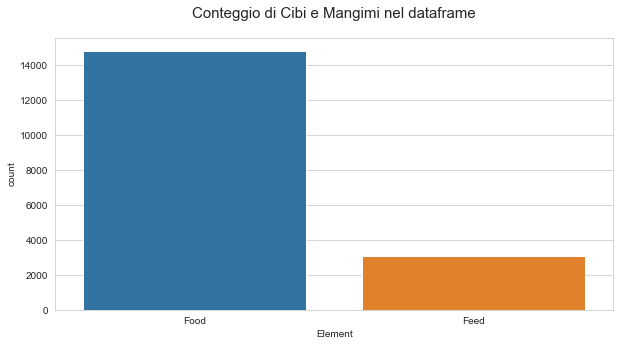

In [178]:
plt.figure(figsize=(10,5))

sns.countplot(x='Element', data=df_prod)

plt.title('Conteggio di Cibi e Mangimi nel dataframe',size=15, pad=20)
plt.show()

Come prevedibile, gli elementi che riguardano il cibo sono molto più presenti nel dataframe, rispetto ai mangimi. 

Come è variata nel tempo la produzione di tutti i beni che riguardano i cibi e i mangimi, indipendentemente dal paese produttore e dagli elementi specifici?

In [180]:
# Lista di anni dal 1961 al 2013
years_of_production = [str(n) for n in range(1961, 2014)]

# Creo un dataframe raggruppando cibi e mangimi e sommando i quantitativi prodotti ogni anno 
total_production = df_prod.groupby('Element')[years_of_production].sum()

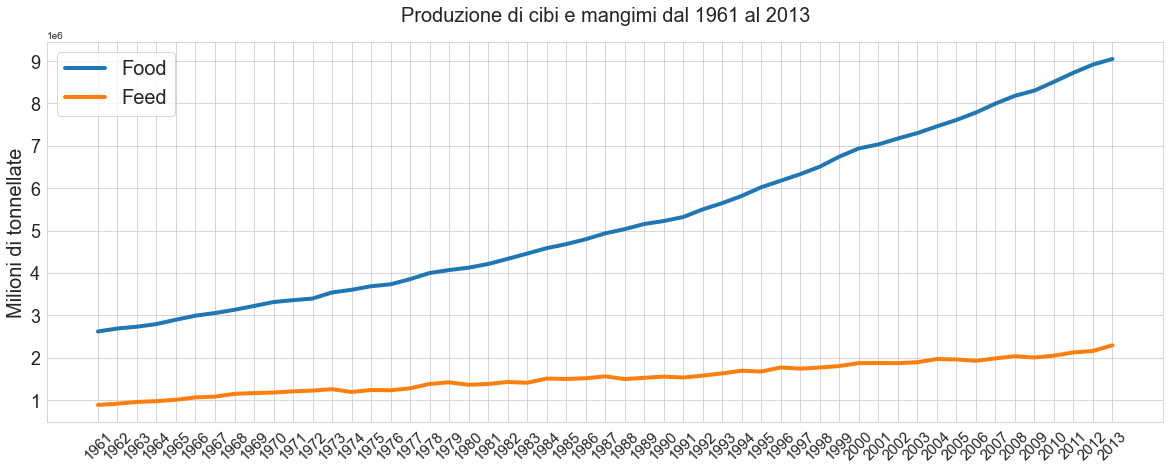

In [208]:
sns.set_style('whitegrid')

plt.figure(figsize=(20,7))

sns.lineplot(data=total_production.loc['Food'], label='Food', linewidth=4)
sns.lineplot(data=total_production.loc['Feed'], label='Feed', linewidth=4)

plt.title('Produzione di cibi e mangimi dal 1961 al 2013', size=20, pad=20)

plt.ylabel('Milioni di tonnellate', size=20)
plt.yticks(size=18)

plt.xticks(rotation=45, size=15)

plt.legend(loc=2, prop={'size': 20})
plt.show()

Possiamo vedere quanto sono aumentate nel tempo le produzioni di cibo e mangimi. La produzione di mangimi è più che raddoppiata dal 1961 al 2013, mentre la produzione di cibo è più che triplicata! 

Vediamo ora quali sono stati i massimi valori di produzione nel 1961 e nel 2013 e quali sono il cibo, il mangime, e il paese più frequenti all'interno del dataframe.

In [228]:
aggregations = {
    'Max production 1961':pd.NamedAgg('1961', 'max'),
    'Max production 2013':pd.NamedAgg('2013', 'max'),
    'Most common product':pd.NamedAgg('Item', lambda n:n.mode()),
    'Most common country ':pd.NamedAgg('Area', lambda n:n.mode())}
    # 'no_cabin_info_ratio':pd.NamedAgg('Cabin', lambda c:c.isna().sum()/c.size),
    # 'cabin_known_info_ratio':pd.NamedAgg('Cabin', lambda c:c.notna().sum()/c.size)}


df_prod.groupby('Element').agg(**aggregations)

,Max production 1961,Max production 2013,Most common product,Most common country
Element,,,,
Feed,112227,193043,Milk,China
Food,74071,489299,"[Eggs, Milk]",China


In [ ]:
# filtro e dataframe cibo
food = df_prod.Element == 'Food'
only_food = df_prod.loc[food]

# filtro e dataframe mangime
feed = df_prod.Element == 'Feed'
only_feed = df_prod.loc[feed]